In [2]:
library(tidyverse)


Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [3]:
repo_dir <- normalizePath('../../..')

In [4]:
figure_out <-   file.path(repo_dir, 'figs/Fig3_AllVariants/', 'Fig3B_GREAT.pdf')  


In [5]:
ontology <- 'MGIPhenotype'
score <- 'BFold'

dataset <- 'dev_allNonMHC_z_center_p0001_100PCs_20180129.npz'
phenotype_str <- 'Body_mass_index__BMI_'

In [6]:
phenotype_dir <- file.path(
    repo_dir, 
    'private_data/results',
    dataset,
    'phenotypes',
    phenotype_str
)
circos_data  <- file.path(phenotype_dir, 'great', ontology, 'circos-data.csv')
cosine_score <- file.path(phenotype_dir, 'squared_cosine_scores.tsv') 


In [7]:
if(score == 'BFold'){
    data <- read_csv(circos_data)  %>% 
    mutate(Score = BFold, Alpha = -log10(BPval)) %>% 
    select(-PC_rank, -BFold, -BPval) %>%
    rename(
        Group_id = PC,
        Label = Term
    )    
}else if(score == 'BPval'){
    data <- read_csv(circos_data)  %>% 
    mutate(Alpha = BFold, Score = -log10(BPval)) %>% 
    select(-PC_rank, -BFold, -BPval) %>%
    rename(
        Group_id = PC,
        Label = Term
    )    
    
}


Parsed with column specification:
cols(
  PC_rank = col_integer(),
  PC = col_character(),
  Term = col_character(),
  BFold = col_double(),
  BPval = col_double()
)


In [8]:
groups <- read.table(cosine_score) %>% 
rename(
    Group_order = V1,
    PC_zero_based = V2,
    Group_fraction = V3
) %>% mutate(
    Group_id = paste0('PC', PC_zero_based + 1)
) %>% select(-PC_zero_based)


In [9]:
compute_loc_from_width <- function(df, loc_margin=0.05){
    # Given a data frame with 'width' column, 
    # compute location parameters for plot
    df %>% 
    mutate(
        loc_start = cumsum(width) - (1 - loc_margin) * width,
        loc_end = cumsum(width) - loc_margin * width,
        loc = 0.5 * (loc_start + loc_end),
        angle = 90 - 360 * loc,
        hjust = ifelse(angle < -90, 1, 0),
        angle = ifelse(angle < -90, angle+180, angle),            
    )
}


In [10]:
scale_alpha <- function(df, quantile_thr = 0.05, alpha_min=0.3){
    # Given a data frame with 'Alpha' column, 
    # scale it to Alpha_scaled column such that they are in [alpha_min, 1]
    # interval.
    a_quant_min <- quantile(df$Alpha, quantile_thr)
    a_quant_max <- quantile(df$Alpha, 1 - quantile_thr)
    df %>% 
    mutate(
        Alpha_tmp1 = (1 - alpha_min) * (Alpha - a_quant_min) / (a_quant_max - a_quant_min),
        Alpha_tmp2 = ifelse(Alpha_tmp1 <= 0, 0, Alpha_tmp1),
        Alpha_scaled = ifelse(Alpha_tmp2 >= 1, 1, Alpha_tmp2),
    ) %>% select(
        -Alpha_tmp1, -Alpha_tmp2
    )    
}


In [11]:
circular_bar_plot <- function(data, groups, loc_margin=0.05, quantile_thr=0.05, alpha_min=0.3){
    # augument data for the groups
    groups_plot <- groups %>% 
    right_join(
        data %>% group_by(Group_id) %>% summarise(num = n()),
        by='Group_id') %>% 
    mutate(
        bar_width = Group_fraction/num, width = Group_fraction) %>% 
    arrange(Group_order) %>% 
    compute_loc_from_width(loc_margin = loc_margin) 

    # augument data for the bar
    data_plot <- data %>% 
    left_join(
        groups_plot %>% select(-loc, -loc_start, -loc_end, -angle, -hjust, -width),
        by='Group_id') %>% 
    rename( width = bar_width) %>% 
    arrange(Group_order, -Score) %>%
    compute_loc_from_width() %>%
    scale_alpha(quantile_thr = quantile_thr, alpha_min = alpha_min)

    # compute parameters for the plot
    y_lim_max <- data_plot %>% select(Score) %>% max() + 1
    geom_segment_y_val <- floor(1.2 * (y_lim_max - 1) / 5) * 5

    # plot
    data_plot %>%
    ggplot(
        aes(x=loc, y=Score, fill= Group_id, width=0.9 * width, label=Label)) + 
    geom_bar(
        stat="identity", alpha=data_plot$Alpha_scaled) +
    xlim(0, 1) + ylim(-5, y_lim_max + 1) + coord_polar() + theme_minimal() +
    theme(
        legend.position = "none", panel.grid = element_blank(),
        axis.text = element_blank(), axis.title = element_blank(),
        plot.margin = unit(rep(-1,4), "cm") ) +
    geom_segment(
        x=0, xend=1, y=0, yend=0, 
        color='grey', alpha=1, size=0.3, inherit.aes = FALSE)+
    geom_segment(
        x=0, xend=1, y=geom_segment_y_val * 0.5, yend=geom_segment_y_val * 0.5, 
        color='grey', alpha=1, size=0.3, inherit.aes = FALSE)+
    annotate(
        "text", x = rep(1,2), y = c(0, geom_segment_y_val * 0.5), 
        label = c("0", geom_segment_y_val * 0.5) , color="grey", 
        size=6 , angle=0, fontface="bold", hjust=1) +    
    geom_segment(
        x=0, xend=1, y=geom_segment_y_val, yend=geom_segment_y_val, 
        color='grey', alpha=1, size=0.3, inherit.aes = FALSE)+    
    annotate(
        "text", x = rep(1,2), y = c(0, geom_segment_y_val), 
        label = c("0", geom_segment_y_val) , color="grey", 
        size=6 , angle=0, fontface="bold", hjust=1) +
    geom_segment( 
        data=groups_plot, aes(x = loc_start, xend = loc_end, y = -.3, yend = -.3), 
        color = "black", alpha=0.8, size=0.6, inherit.aes = FALSE) +
#    geom_text( # annotation on the bars
#        data=data_plot, aes(x=loc, y=Score+0.5, label = Label),
#        color="black", fontface="bold", alpha=.6, size=data_plot$width * 180, position="stack",
#        hjust=data_plot$hjust, angle=data_plot$angle, inherit.aes = FALSE) +
    geom_text( # annotation on the inner circle (groups)
        data=groups_plot, aes(x = loc, y = -1.5, label=Group_id), 
        color = "black", fontface="bold", alpha=0.8, 
        size=ifelse(groups_plot$width > 0.1, 2, 1), 
        angle=ifelse(groups_plot$width > 0.1, groups_plot$angle - 90, groups_plot$angle), 
        hjust=ifelse(groups_plot$width > 0.1, .5, groups_plot$hjust), 
        inherit.aes = FALSE)    
}



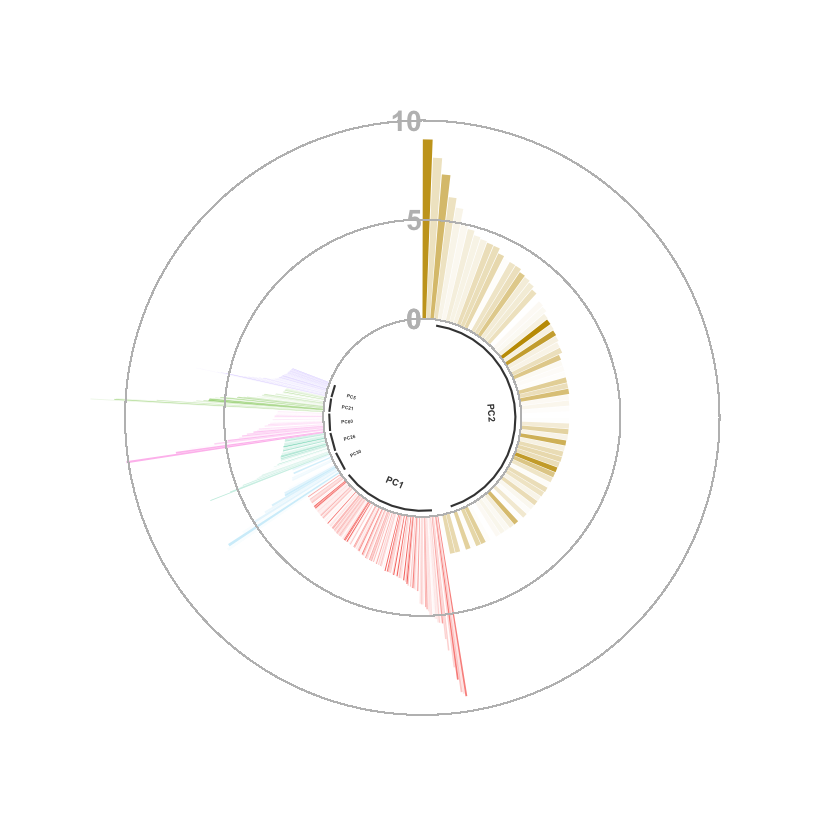

In [12]:
circular_bar_plot(data, groups, loc_margin=0.05, quantile_thr=0.05, alpha_min=0.3)
